In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
#!pip install transformers accelerate optimum vllm llama-cpp-python

In [3]:
!pip install transformers

In [4]:
!pip install accelerate

In [5]:
!pip install optimum

In [6]:
import vllm 

In [7]:
!pip install llama-cpp-python

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "./Meta-Llama-3-8B"  # Path to the cloned model directory
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)

c:\Users\danie\Downloads\RFNet-4D-main\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [16]:
##Pre-emptive test##
import time

start_time = time.time()

prompt = "What are the key financial risks in SEC filings?"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_new_tokens=256)

print(tokenizer.decode(output[0], skip_special_tokens=True))
print(f"Time taken: {time.time() - start_time} sec")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


What are the key financial risks in SEC filings? We looked at all the 10-Ks and 10-Qs filed by S&P 500 companies in the first half of 2017 to find out.
In this article, we’ll look at the key financial risks in SEC filings. We’ll also look at how companies are responding to those risks.
We looked at all the 10-Ks and 10-Qs filed by S&P 500 companies in the first half of 2017 to find out.
We found that the most common financial risks were credit risk, liquidity risk, and market risk. These risks were mentioned in 62% of all SEC filings.
We also found that the most common responses to these risks were to diversify investments, to hedge against market fluctuations, and to use derivatives to reduce risk.
What are the key financial risks in SEC filings?
The key financial risks in SEC filings are credit risk, liquidity risk, and market risk. These risks are often mentioned in the same paragraph, and they are all related to the company’s ability to meet its financial obligations.
Credit risk i

In [9]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install bert-score 

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install rouge_score absl-py

Note: you may need to restart the kernel to use updated packages.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be

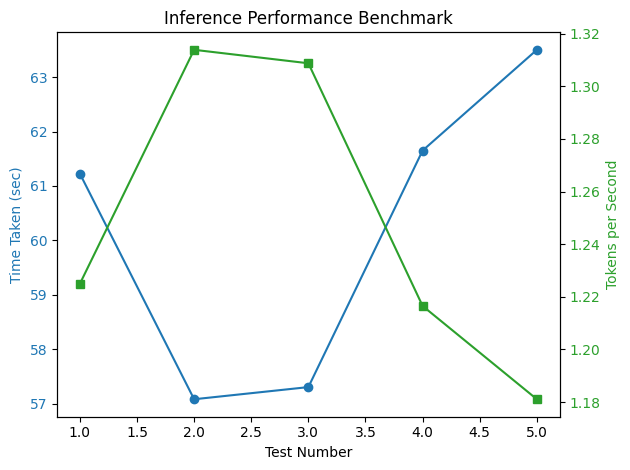

Average Perplexity: 2392064.00
Average ROUGE Score: 0.2397
Average BLEU Score: 0.1209
Average Edit Distance: 342.20
Average BERTScore: 0.4096
Win Rate: 0.00%
Average Token Throughput: 1.25 tokens/sec


In [5]:
import time
import torch
import matplotlib.pyplot as plt
import evaluate
import Levenshtein
from transformers import AutoModelForCausalLM, AutoTokenizer
from Levenshtein import distance as levenshtein_distance
from bert_score import score as bert_score

# Load evaluation metrics using the evaluate package
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Test prompt
prompt = "What are the key financial risks in SEC filings?"

# Initialize lists for performance metrics
time_taken_list = []
tokens_per_second_list = []
perplexity_list = []
rouge_scores = []
bleu_scores = []
edit_distance_list = []
bert_score_list = []
win_rate_list = []

# Number of test runs
num_tests = 5  
win_threshold = 0.8  # BERTScore threshold for Win% calculation

# Ensure model is in evaluation mode
model.eval()

# Run multiple tests to gather performance data
for _ in range(num_tests):
    # Start timing
    start_time = time.time()

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate output (Disable gradients for speed-up)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=64)

    # Decode output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Measure inference time
    time_taken = time.time() - start_time
    time_taken_list.append(time_taken)

    # Compute tokens per second
    num_tokens = len(inputs["input_ids"][0]) + 64  # Adjusted for new token limit
    tokens_per_second = num_tokens / time_taken
    tokens_per_second_list.append(tokens_per_second)

    # Compute Perplexity
    with torch.no_grad():
        logits = model(**inputs).logits
        perplexity = torch.exp(torch.nn.functional.cross_entropy(logits[:, -1, :], inputs["input_ids"][:, -1]))
        perplexity_list.append(perplexity.item())

    # Compute ROUGE score using evaluate package
    rouge_result = rouge.compute(predictions=[decoded_output], references=[prompt])
    rouge_scores.append(rouge_result["rougeL"])

    # Compute BLEU score using evaluate package
    bleu_result = bleu.compute(predictions=[decoded_output], references=[prompt])
    bleu_scores.append(bleu_result["bleu"])

    # Compute Edit Distance
    edit_distance = levenshtein_distance(decoded_output, prompt)
    edit_distance_list.append(edit_distance)

    # Compute BERTScore
    P, R, F1 = bert_score([decoded_output], [prompt], lang="en", rescale_with_baseline=True)
    bert_score_list.append(F1.mean().item())

    # Compute Win Rate (if BERTScore > threshold, consider it a "win")
    win_rate_list.append(1 if F1.mean().item() >= win_threshold else 0)

# Plot Performance Data
fig, ax1 = plt.subplots()

# Plot time taken
ax1.set_xlabel('Test Number')
ax1.set_ylabel('Time Taken (sec)', color='tab:blue')
ax1.plot(range(1, num_tests + 1), time_taken_list, color='tab:blue', marker='o', label='Time Taken')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for tokens per second
ax2 = ax1.twinx()
ax2.set_ylabel('Tokens per Second', color='tab:green')
ax2.plot(range(1, num_tests + 1), tokens_per_second_list, color='tab:green', marker='s', label='Tokens per Second')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Inference Performance Benchmark')
fig.tight_layout()
plt.show()

# Display Performance Metrics
print(f"Average Perplexity: {sum(perplexity_list) / num_tests:.2f}")
print(f"Average ROUGE Score: {sum(rouge_scores) / num_tests:.4f}")
print(f"Average BLEU Score: {sum(bleu_scores) / num_tests:.4f}")
print(f"Average Edit Distance: {sum(edit_distance_list) / num_tests:.2f}")
print(f"Average BERTScore: {sum(bert_score_list) / num_tests:.4f}")
print(f"Win Rate: {sum(win_rate_list) / num_tests * 100:.2f}%")
print(f"Average Token Throughput: {sum(tokens_per_second_list) / num_tests:.2f} tokens/sec")



Average Perplexity: 2392064.00

This value is very high, indicating that the model's predictions are still far from the true distribution of the data. Perplexity is a measure of how well the model predicts the next word in a sequence; a high value like this suggests that the model struggles to generate coherent or accurate outputs. (Low is better.)

Average ROUGE Score: 0.2397

This ROUGE score is quite low, which suggests that the generated text has limited overlap with the reference text. ROUGE measures recall, so a lower score means the model isn't generating much content similar to the target output. (High is better.)

Average BLEU Score: 0.1209

The BLEU score is also low here, meaning the model's output is not closely aligned with the reference text in terms of n-gram overlap. A score of ~0.12 suggests the model is not producing precise, high-quality output. (High is better.)

Average Edit Distance: 342.20

The edit distance is relatively high, indicating a larger difference between the generated output and the reference text. This means the model’s output has significant errors or inconsistencies compared to the reference. (Low is better.)

Average BERTScore: 0.4096

The BERTScore of 0.4096 indicates that the model's output has a moderate level of semantic similarity with the reference text, but it's still not ideal. Higher values suggest the output is semantically closer to the target, so a score around 0.4 shows there's room for improvement in capturing meaningful content. (High is better.)

Win Rate: 0.00%

The model did not meet the BERTScore threshold (0.8) in any of the test cases. This means that the outputs generated by the model were not sufficiently close to the reference texts, failing to meet a predefined threshold of semantic similarity. (High is better.)

Average Token Throughput: 1.25 tokens/sec

This value represents the speed at which the model processes tokens, but at 1.25 tokens per second, it is quite slow. A higher token throughput is generally desired to increase the model’s efficiency and responsiveness. (High is better.)

In [20]:
pip install flash-attn

  Using cached flash_attn-2.7.4.post1.tar.gz (6.0 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\danie\\AppData\\Local\\Temp\\pip-install-jl32t6ga\\flash-attn_8703d422f7c14f1e8b57100027643e47\\csrc\\composable_kernel\\library\\include\\ck\\library\\tensor_operation_instance\\gpu\\grouped_conv_bwd_weight\\device_grouped_conv_bwd_weight_two_stage_xdl_instance.hpp'



Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.

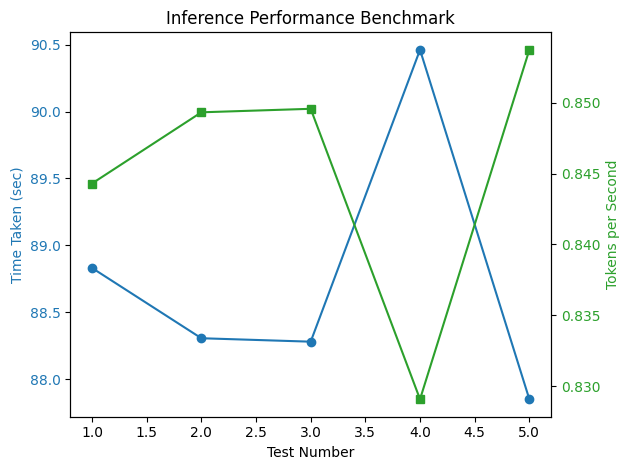

Average Perplexity: 69.68
Average ROUGE Score: 0.2344
Average BLEU Score: 0.1166
Average Edit Distance: 323.40
Average BERTScore: 0.4206
Win Rate: 0.00%
Average Token Throughput: 0.85 tokens/sec


In [4]:
import time
import torch
import matplotlib.pyplot as plt
import evaluate
import Levenshtein
from transformers import AutoModelForCausalLM, AutoTokenizer
from Levenshtein import distance as levenshtein_distance
from bert_score import score as bert_score

# Load evaluation metrics using the evaluate package
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Test prompt
prompt = "What are the key financial risks in SEC filings?"

# Initialize lists for performance metrics
time_taken_list = []
tokens_per_second_list = []
perplexity_list = []
rouge_scores = []
bleu_scores = []
edit_distance_list = []
bert_score_list = []
win_rate_list = []

# Number of test runs
num_tests = 5  
win_threshold = 0.8  # BERTScore threshold for Win% calculation

# Load Model
model_path = "./Meta-Llama-3-8B"  # Path to the cloned model directory
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)

# Ensure model is in evaluation mode
model.eval()

# Run multiple tests to gather performance data
for _ in range(num_tests):
    # Start timing
    start_time = time.time()

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)  # Move inputs to the same device as the model

    # Generate output (Disable gradients for speed-up)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=64)

    # Decode output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Measure inference time
    time_taken = time.time() - start_time
    time_taken_list.append(time_taken)

    # Compute tokens per second
    num_tokens = len(inputs["input_ids"][0]) + 64  # Adjusted for new token limit
    tokens_per_second = num_tokens / time_taken
    tokens_per_second_list.append(tokens_per_second)

    # Compute Perplexity (Corrected)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])  # Pass input_ids as labels for loss calculation
        loss = outputs.loss  # Cross-entropy loss
        perplexity = torch.exp(loss).item()  # Perplexity is the exponential of the loss
        perplexity_list.append(perplexity)

    # Compute ROUGE score using evaluate package
    rouge_result = rouge.compute(predictions=[decoded_output], references=[prompt])
    rouge_scores.append(rouge_result["rougeL"])

    # Compute BLEU score using evaluate package
    bleu_result = bleu.compute(predictions=[decoded_output], references=[prompt])
    bleu_scores.append(bleu_result["bleu"])

    # Compute Edit Distance
    edit_distance = levenshtein_distance(decoded_output, prompt)
    edit_distance_list.append(edit_distance)

    # Compute BERTScore
    P, R, F1 = bert_score([decoded_output], [prompt], lang="en", rescale_with_baseline=True)
    bert_score_list.append(F1.mean().item())

    # Compute Win Rate (if BERTScore > threshold, consider it a "win")
    win_rate_list.append(1 if F1.mean().item() >= win_threshold else 0)

# Plot Performance Data
fig, ax1 = plt.subplots()

# Plot time taken
ax1.set_xlabel('Test Number')
ax1.set_ylabel('Time Taken (sec)', color='tab:blue')
ax1.plot(range(1, num_tests + 1), time_taken_list, color='tab:blue', marker='o', label='Time Taken')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for tokens per second
ax2 = ax1.twinx()
ax2.set_ylabel('Tokens per Second', color='tab:green')
ax2.plot(range(1, num_tests + 1), tokens_per_second_list, color='tab:green', marker='s', label='Tokens per Second')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Inference Performance Benchmark')
fig.tight_layout()
plt.show()

# Display Performance Metrics
print(f"Average Perplexity: {sum(perplexity_list) / num_tests:.2f}")
print(f"Average ROUGE Score: {sum(rouge_scores) / num_tests:.4f}")
print(f"Average BLEU Score: {sum(bleu_scores) / num_tests:.4f}")
print(f"Average Edit Distance: {sum(edit_distance_list) / num_tests:.2f}")
print(f"Average BERTScore: {sum(bert_score_list) / num_tests:.4f}")
print(f"Win Rate: {sum(win_rate_list) / num_tests * 100:.2f}%")
print(f"Average Token Throughput: {sum(tokens_per_second_list) / num_tests:.2f} tokens/sec")




In [2]:
import time
import torch
import matplotlib.pyplot as plt
import evaluate
import Levenshtein
from transformers import AutoModelForCausalLM, AutoTokenizer
from Levenshtein import distance as levenshtein_distance
from bert_score import score as bert_score
from docx import Document
import numpy as np

# Load evaluation metrics using the evaluate package
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# 100 diverse test prompts for a compliance-focused LLM
prompts = [
    "What are the key environmental risks highlighted in this report?",
    "Summarize key cybersecurity vulnerabilities in the filing.",
    "Assess financial statement accuracy based on disclosed risks.",
    "Identify any potential conflicts of interest in governance structures.",
    "What are the tax risks identified in the latest filing?",
    "Highlight any liquidity risks mentioned in this filing.",
    "Evaluate compliance with international anti-bribery laws.",
    "Analyze the impact of market risk factors disclosed in this report.",
    "What are the key risks identified in this company’s supply chain?",
    "Summarize risk factors from the latest 10-Q filing.",
    "Identify any references to potential violations of the Foreign Corrupt Practices Act (FCPA).",
    "What governance issues are raised in this proxy statement?",
    "Detect any conflicts between financial projections and risk disclosures.",
    "Identify operational inefficiencies highlighted in the filing.",
    "Summarize management's response to identified risks.",
    "What mitigation strategies are proposed for identified risks?",
    "Review the risk management framework outlined in the document.",
    "Analyze potential strategic risks identified in the report.",
    "Highlight reputational risks mentioned in the document.",
    "Identify regulatory penalties or fines discussed in the report.",
    "Detect any signs of financial misreporting in the filing.",
    "Analyze the company’s risk appetite based on the disclosed risks.",
    "Identify political risks related to operations in foreign countries.",
    "Assess the adequacy of the company’s disaster recovery plans.",
    "What are the sustainability risks identified in this report?",
    "Summarize legal proceedings related to risk in this filing.",
    "Identify insurance coverage gaps discussed in the filing.",
    "Detect any potential issues with intellectual property management.",
    "Highlight key fraud risks disclosed in the document.",
    "Summarize the company’s risk tolerance as outlined in the filing.",
    "Assess the company’s risk diversification strategy.",
    "Review how the company plans to handle potential supply chain disruptions.",
    "Identify reputational risks related to the company’s brand.",
    "Analyze risk exposure from foreign exchange fluctuations.",
    "Summarize any risks related to customer concentration.",
    "Detect conflicts of interest in the company’s executive compensation plan.",
    "Identify risks related to mergers and acquisitions in the filing.",
    "Analyze whether the company has adequate legal compliance programs.",
    "Review how the company addresses regulatory changes in this document.",
    "Summarize the company’s risk management priorities for the next year.",
    "Assess risks related to changes in government policy.",
    "Identify any material weaknesses in internal controls.",
    "Evaluate the company’s risk management performance over time.",
    "Highlight risks associated with operational outsourcing.",
    "Assess the financial impact of risk events disclosed in the filing.",
    "Summarize risks related to the company’s digital transformation efforts.",
    "Identify key social risks disclosed in the filing.",
    "What are the potential risks associated with the company’s new product launch?",
    "Evaluate the company’s approach to mitigating operational risks.",
    "Summarize risks related to the company’s leadership transitions.",
    "Highlight financial risks related to the company’s capital structure.",
    "What are the potential risks associated with the company’s debt?",
    "Identify any environmental liabilities discussed in the filing.",
    "Assess the company’s readiness for changes in tax law.",
    "What are the key factors contributing to the company’s credit risk?",
    "Analyze the company’s approach to managing legal risks.",
    "Highlight risks related to compliance with labor laws.",
    "What are the financial implications of disclosed risks?",
    "Assess the company’s approach to managing reputation risk.",
    "Summarize the company’s governance structure and related risks.",
    "Identify risks related to competition in the company’s industry.",
    "Analyze risks associated with the company’s expansion strategy.",
    "Evaluate how the company mitigates risks from geopolitical tensions.",
    "Summarize the company’s approach to managing climate-related risks.",
    "Detect any emerging risks in the company’s business environment.",
    "What are the risks associated with the company’s reliance on technology?",
    "Highlight any risks identified in the company’s corporate social responsibility (CSR) reports.",
    "Identify risks associated with intellectual property infringement.",
    "Summarize risks related to compliance with the GDPR.",
    "Evaluate the company’s exposure to risks from commodity price volatility.",
    "What operational risks are associated with the company’s logistics network?",
    "Identify key market risks affecting the company’s performance.",
    "Analyze risks arising from changes in consumer behavior.",
    "Summarize risks related to the company’s reliance on key suppliers.",
    "Identify risks related to changes in the regulatory landscape for healthcare.",
    "Evaluate risks associated with the company’s use of third-party vendors.",
    "What are the risks related to the company’s employee compensation plans?",
    "Summarize risks identified in the company’s sustainability reports.",
    "Identify risks related to the company’s reliance on renewable energy.",
    "Assess the company’s approach to managing risks from natural disasters.",
    "What are the risks related to the company’s strategic investments?",
    "Summarize the risks associated with the company’s real estate holdings.",
    "What are the company’s plans to address emerging regulatory risks?",
    "Detect risks associated with the company’s reliance on digital marketing.",
    "What are the risks associated with the company’s international operations?",
    "Summarize the company’s approach to managing workforce-related risks.",
    "Highlight risks related to the company’s pension liabilities.",
    "Identify risks related to potential supply shortages.",
    "What are the risks associated with the company’s cybersecurity measures?",
    "Assess the company’s compliance with industry-specific regulations.",
    "Summarize risks related to the company’s research and development activities.",
    "What are the potential risks related to the company’s legal disputes?",
    "Identify risks related to changes in consumer privacy laws.",
    "What are the emerging risks in the company’s market?",
    "Summarize risks related to the company’s debt refinancing efforts.",
    "Identify risks associated with fluctuations in raw material prices.",
    "Assess risks related to the company’s foreign investment strategies.",
    "Summarize the company’s risk management approach to emerging markets.",
    "Evaluate the company’s risk management framework against best practices."
]

# Number of test runs
num_tests = 3  
win_threshold = 0.8  # BERTScore threshold for Win% calculation


# Ensure model is in evaluation mode
model.eval()

# Initialize summary containers
results = []

for prompt in prompts:
    # Initialize lists for performance metrics per prompt
    time_taken_list = []
    tokens_per_second_list = []
    perplexity_list = []
    rouge_scores = []
    bleu_scores = []
    edit_distance_list = []
    bert_score_list = []
    win_rate_list = []

    for _ in range(num_tests):
        start_time = time.time()

        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=64, temperature=0.7)

        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

        time_taken = time.time() - start_time
        time_taken_list.append(time_taken)

        num_tokens = len(inputs["input_ids"][0]) + 64
        tokens_per_second = num_tokens / time_taken
        tokens_per_second_list.append(tokens_per_second)

        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            perplexity = torch.exp(loss).item()
            perplexity_list.append(perplexity)

        rouge_result = rouge.compute(predictions=[decoded_output], references=[prompt])
        rouge_scores.append(rouge_result["rougeL"])

        bleu_result = bleu.compute(predictions=[decoded_output], references=[prompt])
        bleu_scores.append(bleu_result["bleu"])

        edit_distance = levenshtein_distance(decoded_output, prompt)
        edit_distance_list.append(edit_distance)

        P, R, F1 = bert_score([decoded_output], [prompt], lang="en", rescale_with_baseline=True)
        f1_score = F1.mean().item()
        bert_score_list.append(f1_score)
        win_rate_list.append(1 if f1_score >= win_threshold else 0)

    # Collect average results for this prompt
    results.append({
        "prompt": prompt,
        "avg_time": sum(time_taken_list) / num_tests,
        "avg_tps": sum(tokens_per_second_list) / num_tests,
        "avg_perplexity": sum(perplexity_list) / num_tests,
        "avg_rouge": sum(rouge_scores) / num_tests,
        "avg_bleu": sum(bleu_scores) / num_tests,
        "avg_edit_distance": sum(edit_distance_list) / num_tests,
        "avg_bert_score": sum(bert_score_list) / num_tests,
        "win_rate": sum(win_rate_list) / num_tests * 100
    })

# Create a Word document
doc = Document()
doc.add_heading('LLM Compliance Evaluation Report', 0)

# Add model and experiment metadata
doc.add_paragraph(f"Model: {model.__class__.__name__}")
doc.add_paragraph(f"Number of test runs per prompt: {num_tests}")
doc.add_paragraph(f"BERTScore Win Threshold: {win_threshold}")

# Add results table
table = doc.add_table(rows=1, cols=9)
table.style = 'Table Grid'
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Prompt'
hdr_cells[1].text = 'Time (s)'
hdr_cells[2].text = 'Tokens/sec'
hdr_cells[3].text = 'Perplexity'
hdr_cells[4].text = 'ROUGE-L'
hdr_cells[5].text = 'BLEU'
hdr_cells[6].text = 'Edit Dist'
hdr_cells[7].text = 'BERTScore'
hdr_cells[8].text = 'Win Rate (%)'

# Add each result to the table
for r in results:
    row_cells = table.add_row().cells
    row_cells[0].text = r['prompt']
    row_cells[1].text = f"{r['avg_time']:.2f}"
    row_cells[2].text = f"{r['avg_tps']:.2f}"
    row_cells[3].text = f"{r['avg_perplexity']:.2f}"
    row_cells[4].text = f"{r['avg_rouge']:.4f}"
    row_cells[5].text = f"{r['avg_bleu']:.4f}"
    row_cells[6].text = f"{r['avg_edit_distance']:.2f}"
    row_cells[7].text = f"{r['avg_bert_score']:.4f}"
    row_cells[8].text = f"{r['win_rate']:.2f}"

# Save the document
doc.save("compliance_llama_baseline_evaluation.docx")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be